# Butterfly & Moths Image Classification for 100 species

This project aims to produce a CNN model with which we can classify the different species of Butterflies and Moths. Generally for most of us there is almost no difference between Butterflies and Moths, due to this general bayes error is quite and only for experts it will be quite low. 

Our goal here is to train a model which is high in accuracy and also efficient to some degree, for this we will use two different CNN Architectures, MobileNet V2 and Inception-Resnet V2. MobileNet V2 and generally all MobileNet are more efficient because of using depth wise convolution. And Inception with Skip connections or Inception-Resnet V2 will be more deeper and more complex model. We will compare accuracy and efficiency of both models and give appropriate conclusion.

The dataset has been sourced from this link:https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species?select=butterflies+and+moths.csv

We have been provided with 3 Data Sets:

1. Train set consists of 12594 images partitioned into 100 sub directories one for each species.
2. Test set consists of 500 images partitioned into 100 sub directories with 5 test images per species.
3. Valid set consists of 500 images partitioned into 100 sub directories with 5 validation images per species.

Size of the images is 224,224,3 for height= width = 224 and RGB channels. This project was done on Kaggle free environment with GPU P100. Training time may vary in different environment

## 1. Packages

In [5]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

import os
import shutil
import json

from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## 2. EDA

For the EDA process we will first load the train, validation, and test datasets.

In [6]:
train_dataset = image_dataset_from_directory('/kaggle/input/butterfly-images40-species/train',
                                             shuffle=True,
                                             batch_size= 32,
                                             image_size= (224,224),
                                             seed=42)

Found 12594 files belonging to 100 classes.


We have 12,549 samples in training dataset. Since images were saved in folders already labeled we can use image_dataset_from_directory function from tensorflow.

In [8]:
validation_dataset = image_dataset_from_directory('/kaggle/input/butterfly-images40-species/valid',
                                             shuffle=True,
                                             batch_size= 32,
                                             image_size= (224,224),
                                             seed=42)

Found 500 files belonging to 100 classes.


Validation dataset has 500 samples.

In [9]:
test_dataset = image_dataset_from_directory('/kaggle/input/butterfly-images40-species/test',
                                             shuffle=True,
                                             batch_size= 32,
                                             image_size= (224,224),
                                             seed=42)

Found 500 files belonging to 100 classes.


And Test datasets has 500 samples too. As per the dataset introduction in Kaggle both test and validation has uniform distributions with each classes having 5 unique examples. We will check this below.

After loading the datasets we will first observe a basic image.

Image Shape = (224, 224, 3)


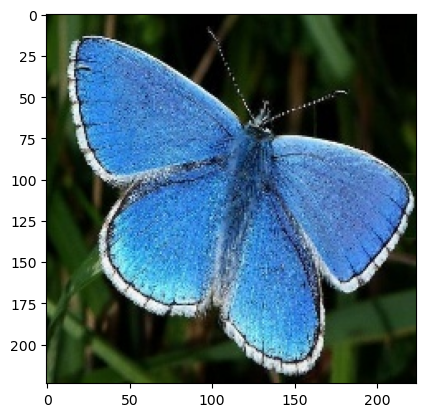

In [10]:
example_path = "/kaggle/input/butterfly-images40-species/train/ADONIS/001.jpg"
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

As we can see from above we are given image of a butterfly/moth with the shape of (224, 224, 3). Now we will observe some images with their labels. 

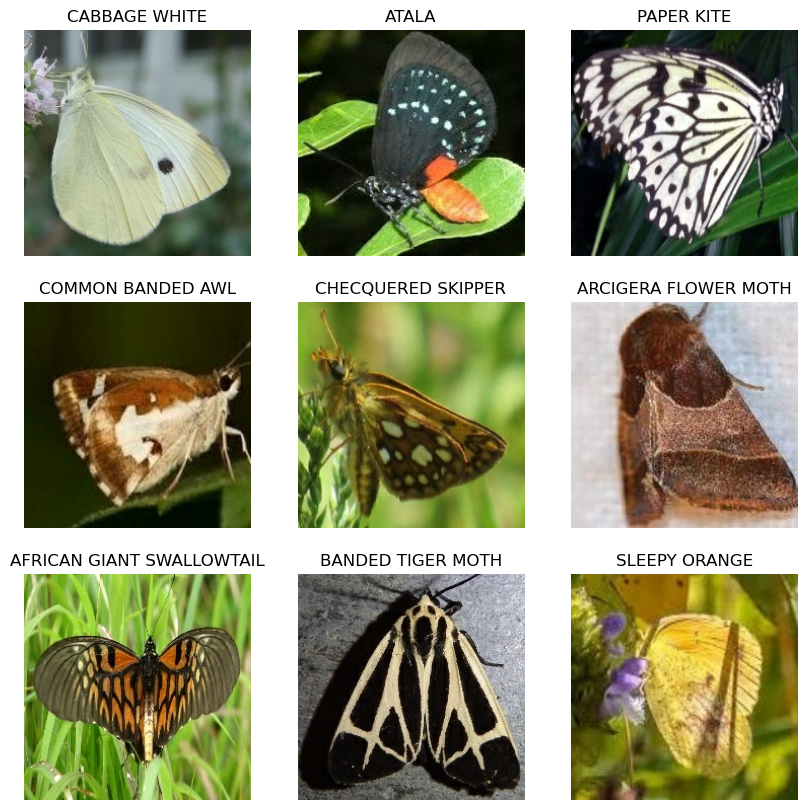

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

We have checked some of the labels and images and they seems to be matched properly. While the dataset has been properly cleaned and provided in Kaggle it is possible that there may exist some misclassification. For this we need some expert help.

However for this project we can only assume that the there is no issues with labelling for all the samples.

Now we will analyse the labels a bit more. And also observe the distributions across Train, Validation, and Test Sets.

In [12]:
df = pd.read_csv('/kaggle/input/butterfly-images40-species/butterflies and moths.csv')
df.head()

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train


In [13]:
df['labels'].value_counts(normalize = True)

MOURNING CLOAK         0.014492
GREEN HAIRSTREAK       0.013683
BROWN ARGUS            0.013168
BROOKES BIRDWING       0.012873
SLEEPY ORANGE          0.011917
                         ...   
ZEBRA LONG WING        0.008386
CRIMSON PATCH          0.008312
MALACHITE              0.008312
WOOD SATYR             0.008239
SIXSPOT BURNET MOTH    0.008092
Name: labels, Length: 100, dtype: float64

In [14]:
len(set(df['labels']))

100

From above cells we can see that we have 100 unique labels with Mourning Cloak having highest proportion among all 3 data sets and Sixspot Burnet Moth having the least propertion.

Now we will check the distributions across the different training sets.

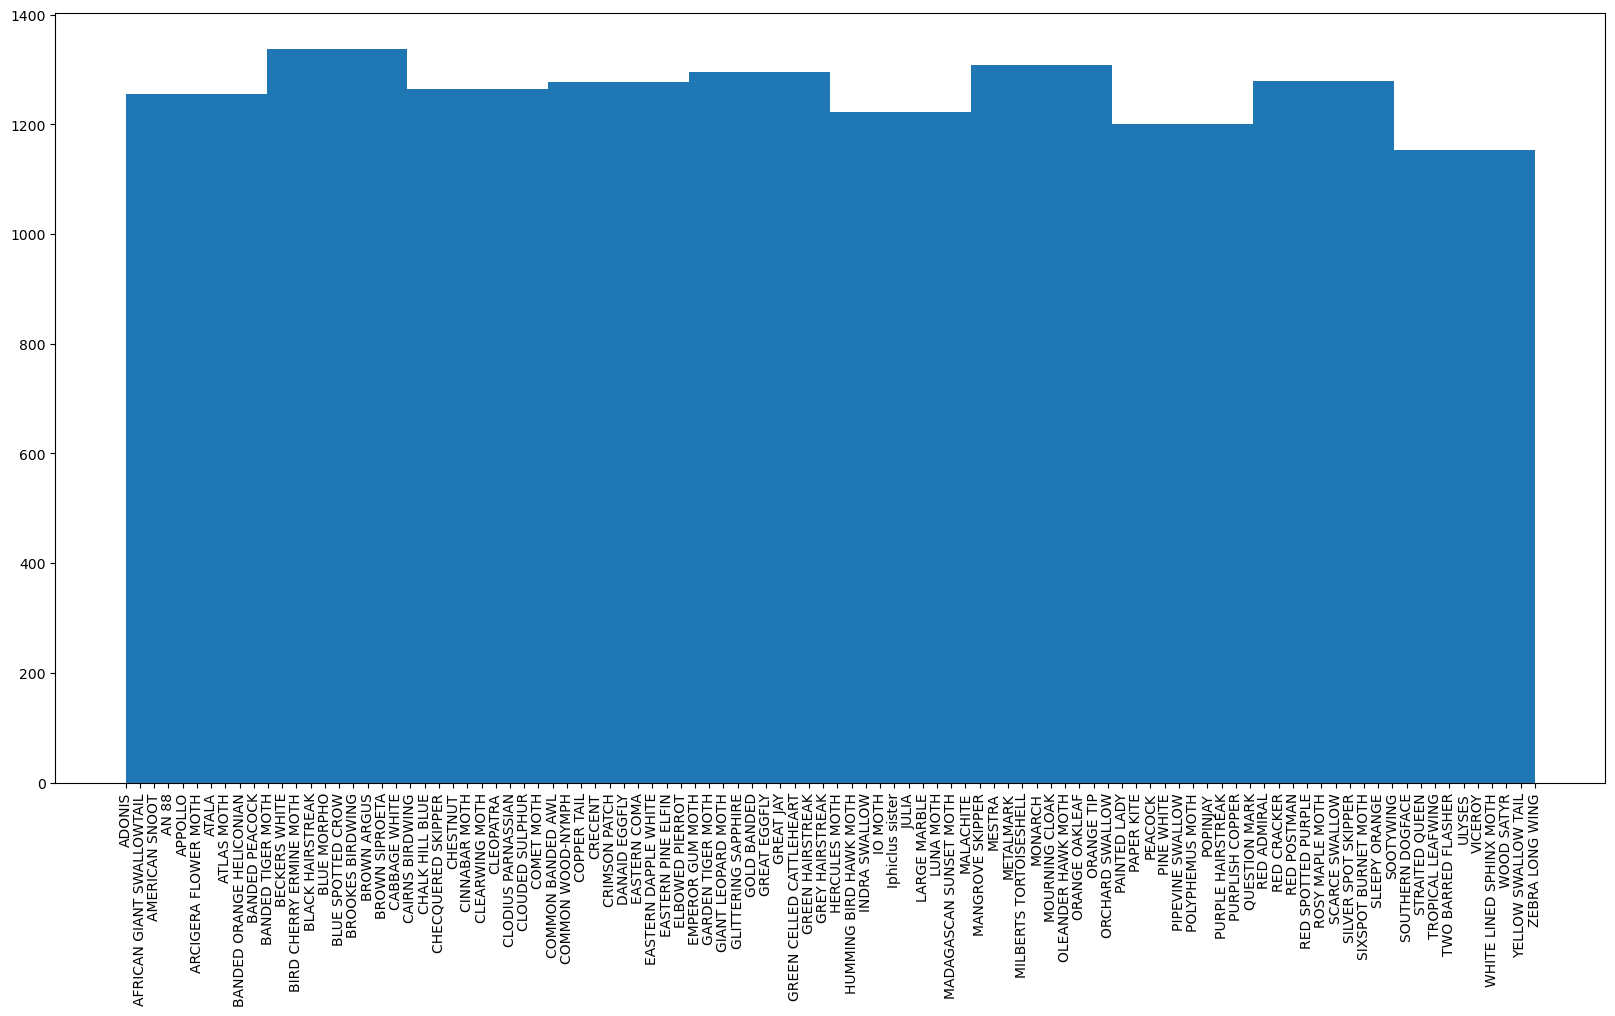

In [15]:
plt.figure(figsize=(20,10))
plt.hist(df[df['data set'] == 'train']['labels'])
plt.xticks(rotation = 90)
plt.show()

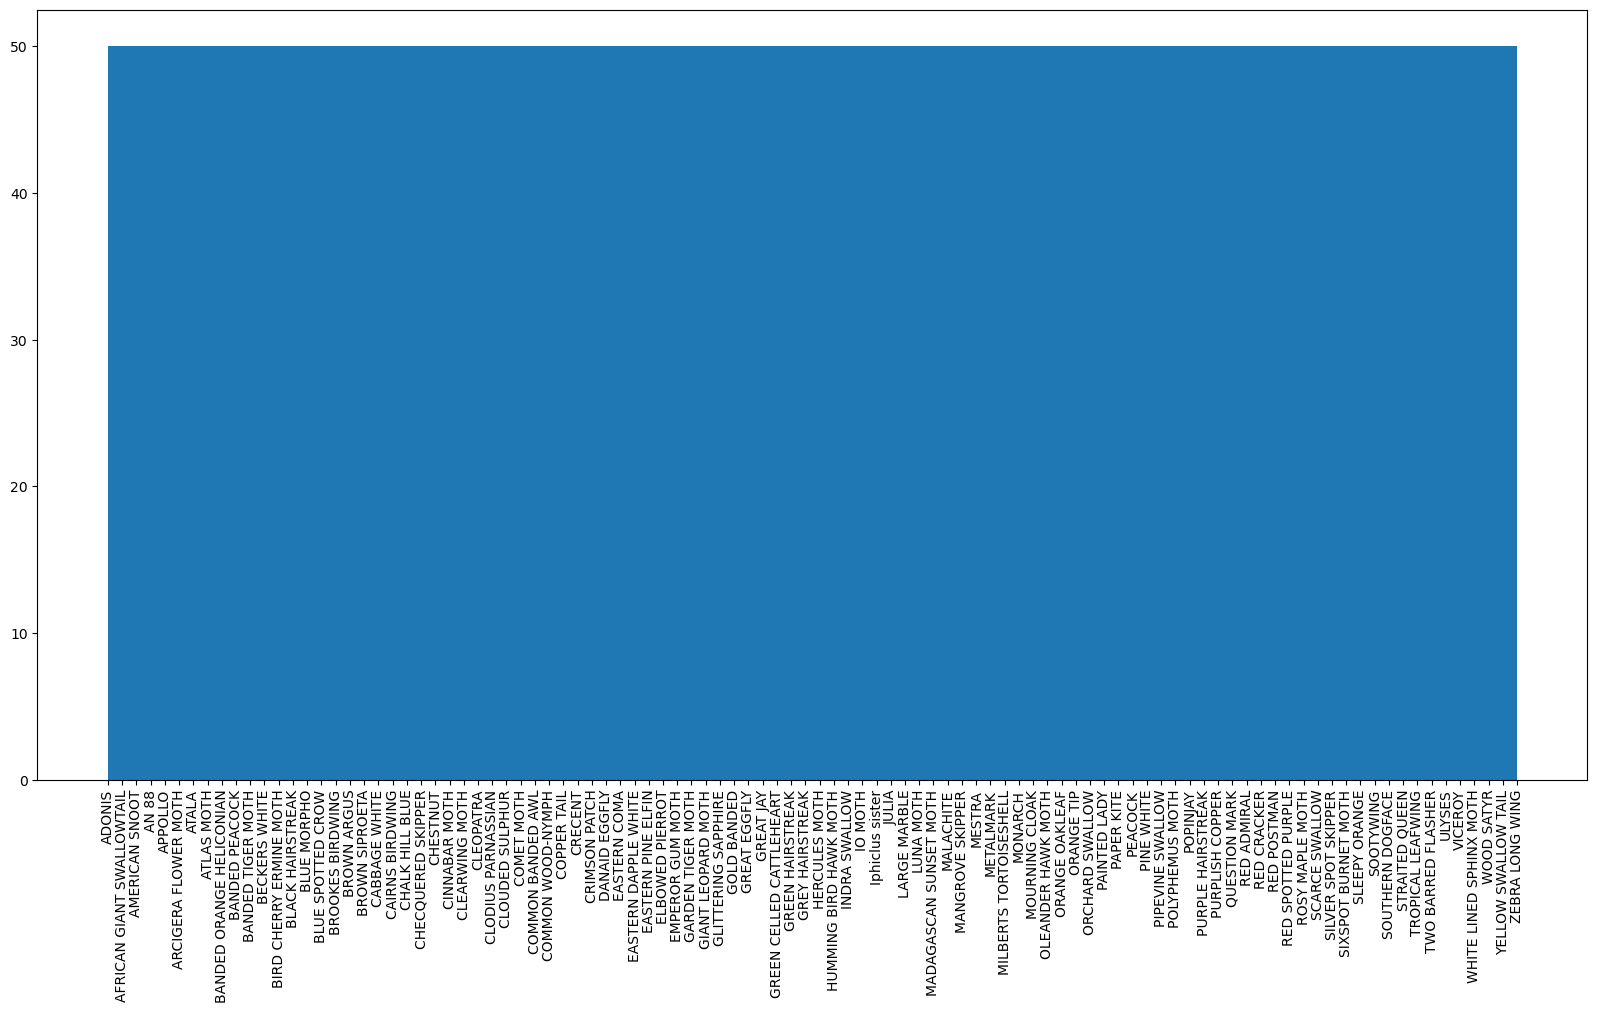

In [16]:
plt.figure(figsize=(20,10))
plt.hist(df[df['data set'] == 'valid']['labels'])
plt.xticks(rotation = 90)
plt.show()

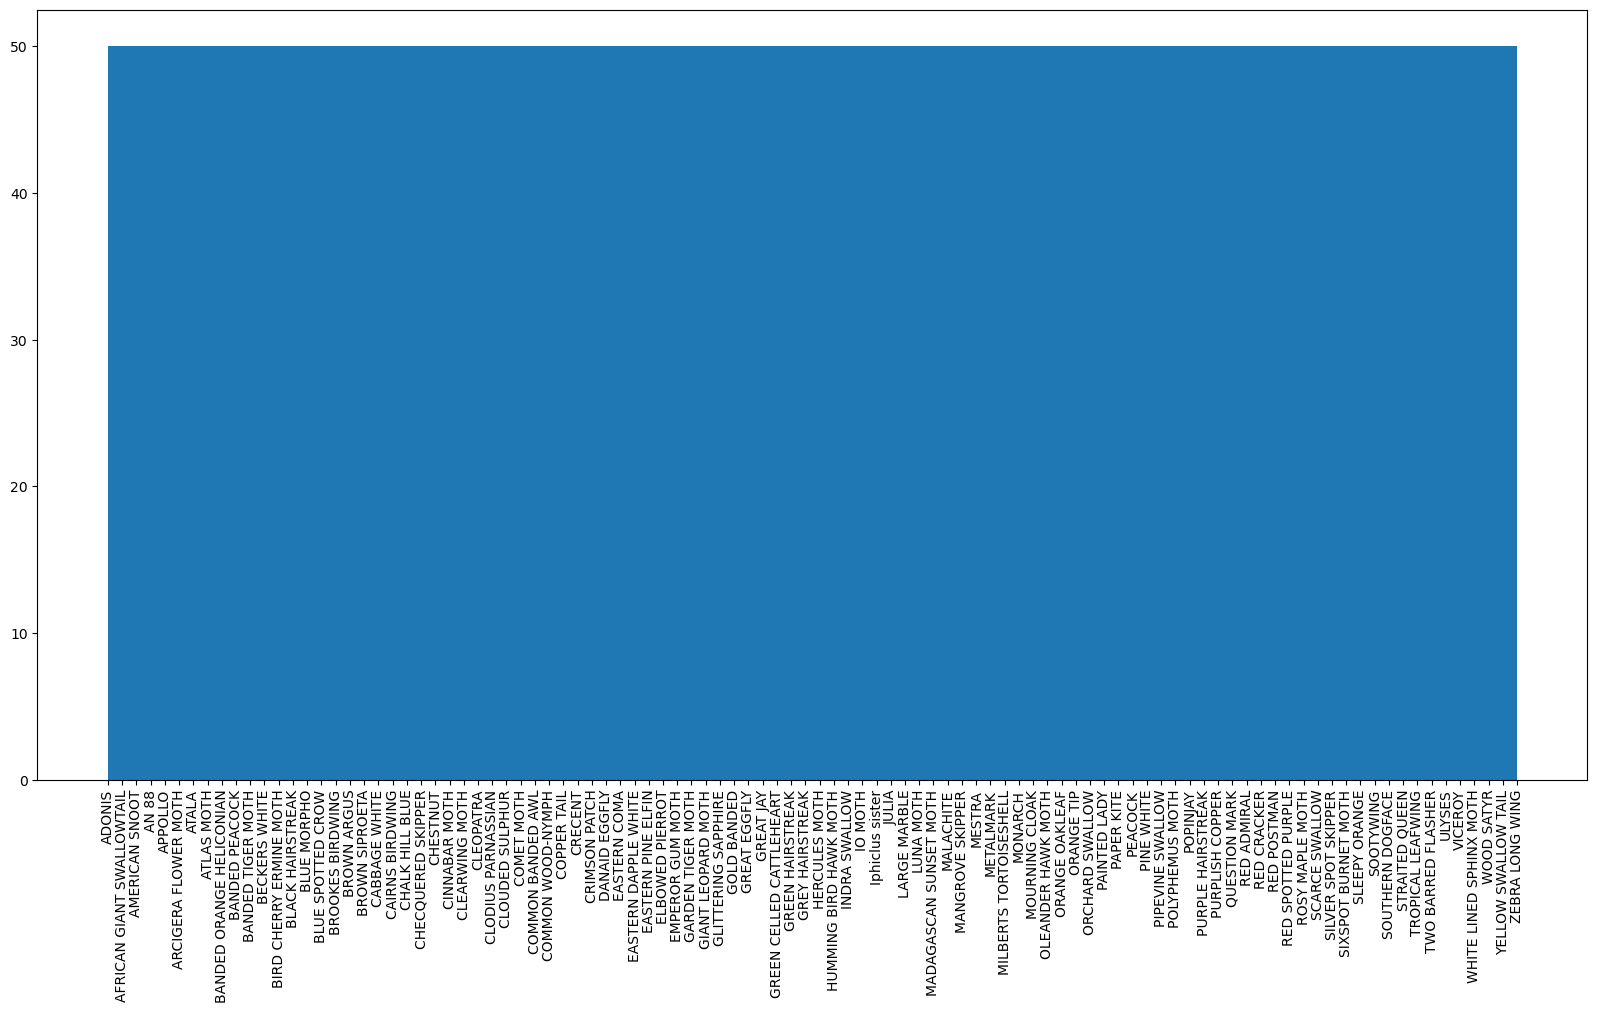

In [17]:
plt.figure(figsize=(20,10))
plt.hist(df[df['data set'] == 'test']['labels'])
plt.xticks(rotation = 90)
plt.show()

In Validation and Test we have uniform distribution and in train we have slight deviation. In Deep Learning it is required both Test and Validation dataset to of same distribution with Training Dataset can tolerate some deviations as we focus to train a better model and for this we can include samples out of distribution. However both Test and Validation must be from same distribution and should reflect the data on which model will be applied.

With this we can conclude EDA. There is no need to tidy the dataset as it already has been cleaned extensively as it gets updated each quarter. We have seen the samples of images and has manually checked the labels from that same sample. Finally we observed the distributions of the Training, Validation, and Test Datasets and have found that there is no major concern regarding this.

## 3. Preprocessing

Since this is an image based modeling we can augment the images as it gets trained. This will increase the model performance overall as random augmentations will push the model to focus to learn the shared parameters better.

We will also use Autotune algorithm for fetching the training images. This will improve the model training efficiency for both MobileNet and Inception-Resnet architecture.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

Now we will test the augmenter and look at the examples of random augmentation which will be applied to Training data.

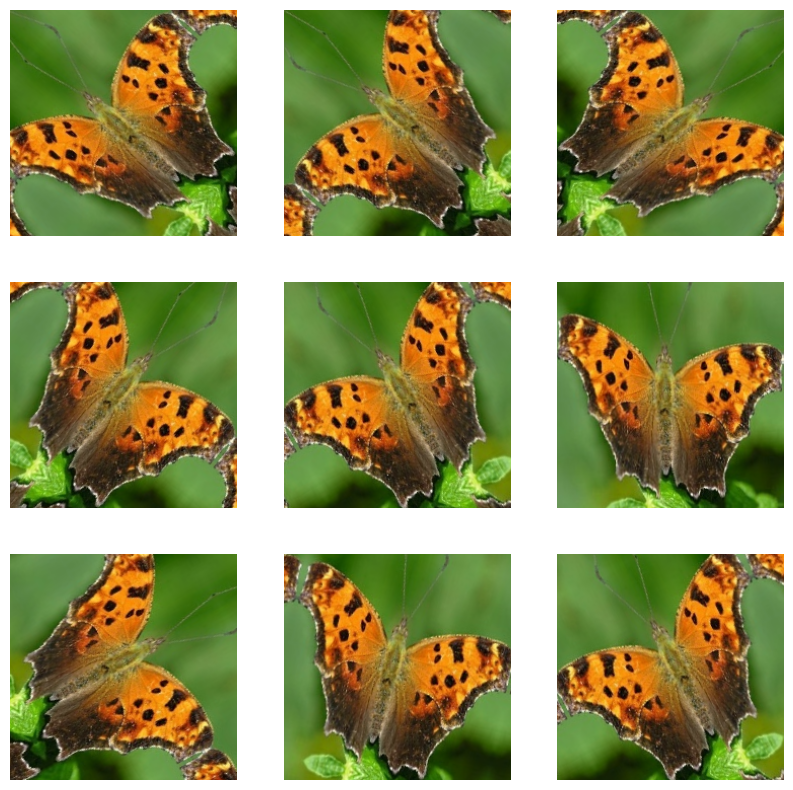

In [20]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 4. Model Creation and Training

In this part we will use functional API of tensorflow to create Mobilenet V2 model and Inception-Resnet model.

For this task we could have used basic CNN Architectures like AlexNet, Lenet5, and others. We could have even created the model from scratch instead of using transfer learning, however we decided to use Mobilenet V2 and Inception-Resnet specifically with transfer learning because of following reasons:
1. MobileNet V2 uses depth-wise convolution which is more efficient than the traditional convolutional process. MobileNet V2 especially also has ability to support skip connections too. This model architecture is based on efficiency, it has over 150 layers but is one of the most efficient CNN architectures.
2. Inception-Resnet as name applies has inception blocks and skip connections. It combine both the features of traditional inception model and traditional resnet models. It's not as efficient as the MobileNet V2 but is a more deeper and complex model with 780 layers.
3. We will use transfer learning as Tensorflows has trained parameters of both models based on ImageNet which inturn was trained over millions of images. We will freeze the early layer parameters and train all other layers while adding our own pooling and fully connected layers for 100 softmax output. Models trained on ImageNet dataset will have similar parameters for early layer if we use millions of butterfly/moth images as the basic features of images like edges will be same in both ImageNet and Butterfly Images dataset.   

Overall instead of basic CNNs both MobileNet V2 and Inception-Resnet are much deeper networks with different architectures. We will train both of them to compare the results while using parameters of Earlier layers trained on massive ImageNet dataset.

We will also fine tune the hyperparameter, especially number of Epochs in each model after their initial training.

### 4.1 MobileNet V2

In [21]:
#This step is important as models stored in tensorflow has specific additional preprocessing steps
preprocess_input_mnet = tf.keras.applications.mobilenet_v2.preprocess_input


In [22]:
#Importing MobileNet V2 while removing the top layers
base_mnet = tf.keras.applications.MobileNetV2(input_shape = (224,224,3),
                                                   include_top = False,
                                                   weights= 'imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [23]:
#In this cell we will use functional API to create a model using our own preprocessing and base_mnet
#We will also apply Average Pooling layer and Droput with 1 Fully connected Dense layer for output

inputs = tf.keras.Input(shape = (224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input_mnet(x)
x = base_mnet(x) 
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(rate = 0.2)(x)

outputs = tfl.Dense(units = 100, activation = 'linear')(x) #We will use from logits = true for more accuracy

model_mnet = tf.keras.Model(inputs, outputs)
model_mnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

We will now use the model above and freeze the earlier layers and train the layers near the output such that we can benefit from the parameters trained on ImageNet for Earlier Layers and train the Later Layers for our project.

We will use ADAM optimizer with learning rate of 0.0001. This learning rate is small because with the parameters of earlier layers already trained we are already near the Global Minima, in order to not overshoot the gradient descent we will use smaller learning rate. We can use try to tune the learning rate in hyperparameter tuning to get faster learning but in case of transfer learning as we applied we have decided to not take the risk. Due to this Learning rate of ADAM will be fixed at 0.0001 and we will not try to tune it further.

We will also use the from_logits = True in Sparse Categorial cross entropy loss in order to get more precise measurements overall. Due to this we used linear activation in last layer of the model, we will obtain logits value from the model and loss will use these logits model for more precise calculations.

In [24]:
mnet_tune = model_mnet.layers[4]
mnet_tune.trainable = True
print("Number of layers in the base Mnet model: ", len(mnet_tune.layers))

Number of layers in the base Mnet model:  154


In [25]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
# We will train the layers from fine_tine_at

for layer in mnet_tune.layers[:fine_tune_at]:
    layer.trainable = False
   
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1*0.001) #Using a smaller learning rate

model_mnet.compile(loss = loss_function,
              optimizer = optimizer,
              metrics = ['accuracy'])

In [26]:
#Checking that trianable has been apploed properly
print(model_mnet.layers[4].layers[99].trainable)
print(model_mnet.layers[4].layers[100].trainable)

False
True


In [27]:
history_mnet = model_mnet.fit(train_dataset,
                         epochs = 20,
                         validation_data = validation_dataset)

Epoch 1/20
394/394 [==============================] - 52s 83ms/step - loss: 1.7618 - accuracy: 0.6328 - val_loss: 0.7132 - val_accuracy: 0.8220
Epoch 2/20
394/394 [==============================] - 20s 51ms/step - loss: 0.4513 - accuracy: 0.8892 - val_loss: 0.3874 - val_accuracy: 0.8860
Epoch 3/20
394/394 [==============================] - 19s 48ms/step - loss: 0.2865 - accuracy: 0.9256 - val_loss: 0.2493 - val_accuracy: 0.9260
Epoch 4/20
394/394 [==============================] - 20s 51ms/step - loss: 0.2249 - accuracy: 0.9400 - val_loss: 0.2204 - val_accuracy: 0.9360
Epoch 5/20
394/394 [==============================] - 21s 51ms/step - loss: 0.1721 - accuracy: 0.9531 - val_loss: 0.1992 - val_accuracy: 0.9500
Epoch 6/20
394/394 [==============================] - 20s 50ms/step - loss: 0.1446 - accuracy: 0.9595 - val_loss: 0.1830 - val_accuracy: 0.9560
Epoch 7/20
394/394 [==============================] - 20s 49ms/step - loss: 0.1118 - accuracy: 0.9691 - val_loss: 0.1906 - val_accuracy:

We got a trained model with acceptable training and validation accuracy and loss within 10 minutes.

We can't tune the learning rate of Adam for various reasons as explained before but now we fine tune the number of Epochs, 

In [28]:
# Hyper Parameter tuning for number of Epochs
# Run it to get additional epochs. We have already tested more epochs and chosen 30 as appropriate 
# measure for further analysis, beyond it there is no major change
# history_mnet_fine = model_mnet.fit(train_dataset,
#                          epochs = 30,
#                          initial_epoch = history_mnet.epoch[-1],
#                          validation_data = validation_dataset)

Epoch 20/30
394/394 [==============================] - 20s 51ms/step - loss: 0.0295 - accuracy: 0.9915 - val_loss: 0.1964 - val_accuracy: 0.9640
Epoch 21/30
394/394 [==============================] - 20s 49ms/step - loss: 0.0345 - accuracy: 0.9879 - val_loss: 0.2110 - val_accuracy: 0.9640
Epoch 22/30
394/394 [==============================] - 19s 48ms/step - loss: 0.0317 - accuracy: 0.9909 - val_loss: 0.2431 - val_accuracy: 0.9600
Epoch 23/30
394/394 [==============================] - 20s 50ms/step - loss: 0.0284 - accuracy: 0.9913 - val_loss: 0.2502 - val_accuracy: 0.9500
Epoch 24/30
394/394 [==============================] - 20s 50ms/step - loss: 0.0257 - accuracy: 0.9928 - val_loss: 0.2348 - val_accuracy: 0.9580
Epoch 25/30
394/394 [==============================] - 19s 47ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.2239 - val_accuracy: 0.9580
Epoch 26/30
394/394 [==============================] - 20s 50ms/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.2014 - val_ac

From the results above we can see that while with more epochs we can get a reduction in training loss to a very small number Validition loss is not changing much overall. While it took only around less than 5 minutes to train for more epochs we can't see any majot improvement in loss and accuracy of both training and validation datasets.

Infact  after 5th Epoch Valdition Loss and Accruacy has hardly changed.

Overall, in 20 epochs we can see that Training Accuracy has converged to 0.99. We can early stop at 6th epoch too but since Training Error has some scope of reduction we have decided to take take Epochs = 20 as the hyperparameters. With this we have done hyper parameter tuning for number of epochs.

### 4.2 Inception-Resnet V2

Now we will train Inception-Resnet V2 Model with very similar steps. This model has 780 layers so we will train more layers than the MobileNet V2. And also like before we will use Hyperparameter tuning on Number of Epochs, not on the Learning Rate of Adam Optimizer because this is transfer learning which is very sensitive to the even small learning rate as 0.001. 

In [30]:
preprocess_input_inception = tf.keras.applications.inception_resnet_v2.preprocess_input


In [32]:
base_inception = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape = (224,224,3),
                                                   include_top = False,
                                                   weights= 'imagenet')

219055592/219055592 [==============================] - 6s 0us/step


In [33]:
inputs = tf.keras.Input(shape = (224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input_mnet(x)
x = base_inception(x) 
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(rate = 0.2)(x)

outputs = tfl.Dense(units = 100, activation = 'linear')(x) #We will use from logits = true for more accuracy

model_inception = tf.keras.Model(inputs, outputs)
model_inception.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                           

In MobileNet V2 we had over 2,350,000 trainable parameters but for inception network we have more than 54 Million parameters. We will use already trained parameters for earlier layers and train 180 layers for our specific butterfly dataset. 

In [35]:
inception_tune = model_inception.layers[4]
inception_tune.trainable = True
print("Number of layers in the base Inception-Resnet model: ", len(inception_tune.layers))

Number of layers in the base Inception-Resnet model:  780


In [38]:
fine_tune_at = 600

# Freeze all the layers before the `fine_tune_at` layer
for layer in inception_tune.layers[:fine_tune_at]:
    layer.trainable = False

print(model_inception.layers[4].layers[599].trainable)
print(model_inception.layers[4].layers[600].trainable)

False
True


In [39]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1*0.001) #Using a smaller learning rate

model_inception.compile(loss = loss_function,
              optimizer = optimizer,
              metrics = ['accuracy'])

In [40]:
history_inception = model_inception.fit(train_dataset,
                         epochs = 20,
                         validation_data = validation_dataset)

Epoch 1/20
394/394 [==============================] - 96s 162ms/step - loss: 1.2917 - accuracy: 0.7082 - val_loss: 0.4395 - val_accuracy: 0.8720
Epoch 2/20
394/394 [==============================] - 58s 147ms/step - loss: 0.3550 - accuracy: 0.9022 - val_loss: 0.2725 - val_accuracy: 0.9340
Epoch 3/20
394/394 [==============================] - 58s 147ms/step - loss: 0.2441 - accuracy: 0.9305 - val_loss: 0.2688 - val_accuracy: 0.9400
Epoch 4/20
394/394 [==============================] - 58s 148ms/step - loss: 0.1760 - accuracy: 0.9512 - val_loss: 0.2546 - val_accuracy: 0.9320
Epoch 5/20
394/394 [==============================] - 59s 149ms/step - loss: 0.1358 - accuracy: 0.9586 - val_loss: 0.2146 - val_accuracy: 0.9460
Epoch 6/20
394/394 [==============================] - 59s 148ms/step - loss: 0.1203 - accuracy: 0.9657 - val_loss: 0.2407 - val_accuracy: 0.9460
Epoch 7/20
394/394 [==============================] - 59s 148ms/step - loss: 0.1013 - accuracy: 0.9697 - val_loss: 0.2149 - val_ac

Inception-Resnet V2 took around twice the time to train compared to MobileNet V2, and results are actually very similar. Validation Accuracy seems to be converged to 0.95 and Validation Loss is also converging to 0.23 and so on. While Training Error and Accuracy can improve further it has also reached a low enough point of 0.99 accuracy and 0.03 error.

Now we will perform hyperparameter tuning for Number of Epochs.

In [43]:
# # Hyper Parameter tuning for number of Epochs
# # Run it to get additional epochs. We have already tested more epochs and chosen 30 as appropriate 
# # measure for further analysis, beyond it there is no major change.

# history_inception_fine = model_inception.fit(train_dataset,
#                          epochs = 30,
#                          initial_epoch = history_inception.epoch[-1],
#                          validation_data = validation_dataset)

Epoch 20/30
394/394 [==============================] - 59s 150ms/step - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.2579 - val_accuracy: 0.9520
Epoch 21/30
394/394 [==============================] - 60s 152ms/step - loss: 0.0377 - accuracy: 0.9887 - val_loss: 0.2577 - val_accuracy: 0.9520
Epoch 22/30
394/394 [==============================] - 59s 149ms/step - loss: 0.0313 - accuracy: 0.9914 - val_loss: 0.2735 - val_accuracy: 0.9600
Epoch 23/30
394/394 [==============================] - 59s 148ms/step - loss: 0.0305 - accuracy: 0.9914 - val_loss: 0.2602 - val_accuracy: 0.9500
Epoch 24/30
394/394 [==============================] - 59s 148ms/step - loss: 0.0309 - accuracy: 0.9918 - val_loss: 0.2550 - val_accuracy: 0.9580
Epoch 25/30
394/394 [==============================] - 59s 148ms/step - loss: 0.0275 - accuracy: 0.9917 - val_loss: 0.2767 - val_accuracy: 0.9500
Epoch 26/30
394/394 [==============================] - 59s 149ms/step - loss: 0.0255 - accuracy: 0.9928 - val_loss: 0.2700 -

Here we tested various number of epochs but beyond 20 epochs we are not able to obtain significant reduction in Training Loss and Validation Loss.

In fact this result is overall very similar to the one obtained in MobileNet V2. In both Training Accuracy/Loss is converging in 20 Epochs and Validation Accuracy/Loss converging even earlier. So here too Epochs = 20 seems to a proper value where we get Train  Accuracy of 0.99 as beyond this there is hardly any improvement in even Training Loss and Accuracy.

## 5. Model Evaluation

Now we will evaluate both models.

We have 2 Models, MobileNet V2 and Inception-ResNet V2. Both of them uses skip connections or residual blocks. MobileNet V2 uses more efficient depth wise convolution with 154 layers while Inception Resnet V2 is much deeper network of 780 hidden layers.

For both we froze earlier layers and trained later layers while adding Pooling layer, dropout layer, and Fully Connected layers. Both of them also used same learning rate and both have Epochs = 20 as optimum number of Epoch hyper parameter.

While both of them even got similar result we will analyse the result here for the final conclusion.

MobileNet V2 Training Accuracy: 0.9909480810165405
MobileNet V2 Validation Accuracy: 0.9739999771118164
MobileNet V2 Training Loss: 0.030378753319382668
MobileNet V2 Validation Loss: 0.173848956823349


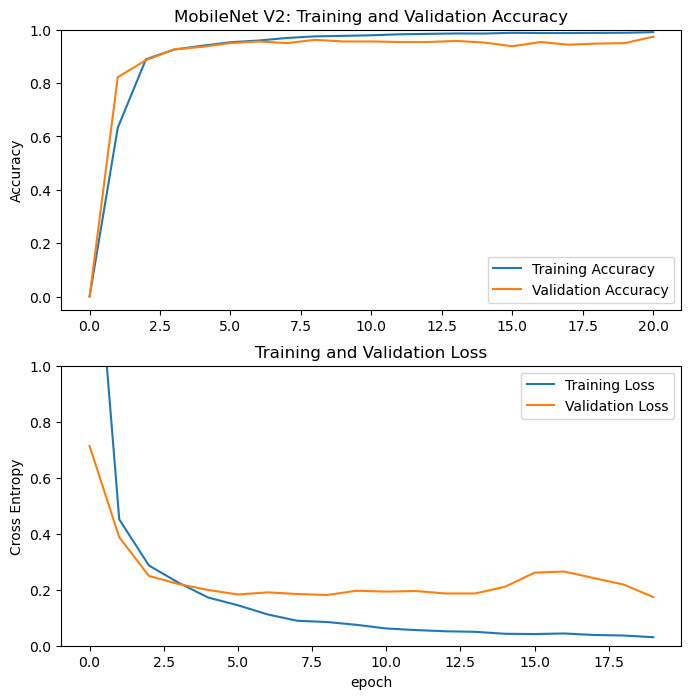

In [46]:
acc = [0.] + history_mnet.history['accuracy']
print('MobileNet V2 Training Accuracy:', acc[-1])
val_acc = [0.] + history_mnet.history['val_accuracy']
print('MobileNet V2 Validation Accuracy:', val_acc[-1])

loss = history_mnet.history['loss']
print('MobileNet V2 Training Loss:', loss[-1])
val_loss = history_mnet.history['val_loss']
print('MobileNet V2 Validation Loss:', val_loss[-1])

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('MobileNet V2: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('MobileNet V2: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Inception ResNet V2 Training Accuracy: 0.9909480810165405
Inception ResNet V2 Validation Accuracy: 0.9909480810165405
Inception ResNet V2 Training Loss: 0.03044644556939602
Inception ResNet V2 Validation Loss: 0.26431331038475037


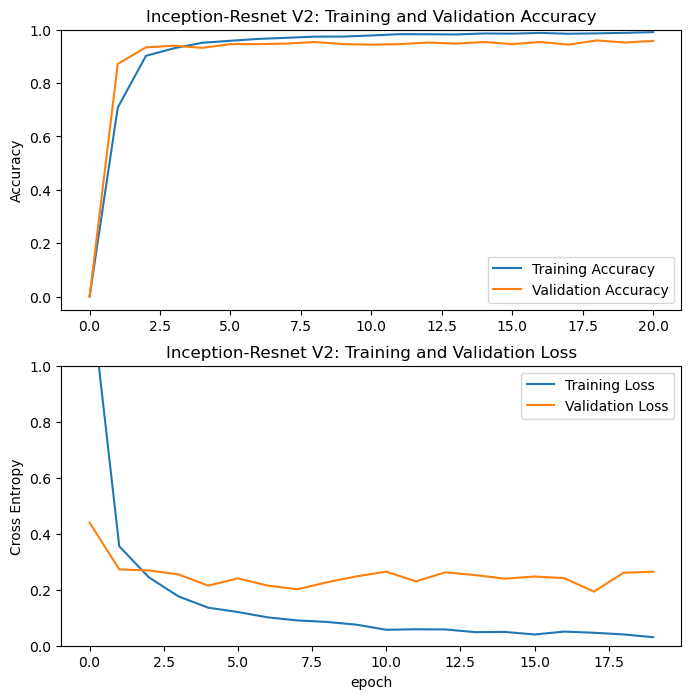

In [50]:
acc_inception = [0.] + history_inception.history['accuracy']
print('Inception ResNet V2 Training Accuracy:', acc_inception[-1])
val_acc_inception = [0.] + history_inception.history['val_accuracy']
print('Inception ResNet V2 Validation Accuracy:', acc_inception[-1])

loss_inception = history_inception.history['loss']
print('Inception ResNet V2 Training Loss:', loss_inception[-1])
val_loss_inception = history_inception.history['val_loss']
print('Inception ResNet V2 Validation Loss:', val_loss_inception[-1])

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_inception, label='Training Accuracy')
plt.plot(val_acc_inception, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Inception-Resnet V2: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_inception, label='Training Loss')
plt.plot(val_loss_inception, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Inception-Resnet V2: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Graphs of both models are very similar. In both Training Loss is converging at 20 Epoch. In both of them Validation Loss is converging in 8 Epochs only.

While Training Accuracy is increasing with more epochs it is converging at 20th epoch at the value of 0.99. This observation is true for both of the models with different architecture. Similarly with more epochs training loss also seems to be decreasing but at 20th epoch it seems to be converging even visually.

We can take Epochs = 30 and get better metric for Training Dataset however we need to look at Validation Metrics instead of Training ones.

Overall both models have similar metrics for both Training and Validation datasets. Next we will evaluate both Models for test dataset for which we will focus specifically on Accuracy as we cant use many metrics as we have a Softmax Application for both models.

In [55]:
test_loss_mnet, test_accuracy_mnet = model_mnet.evaluate(test_dataset)

16/16 [==============================] - 1s 37ms/step - loss: 0.1317 - accuracy: 0.9700


In [54]:
test_loss_inception, test_accuracy_incpetion = model_inception.evaluate(test_dataset)

16/16 [==============================] - 2s 107ms/step - loss: 0.2199 - accuracy: 0.9580


In [58]:
print('MobileNet V2 Test Loss:', test_loss_mnet)
print('MobileNet V2 Test Accuracy:', test_accuracy_mnet)
print('Inception-Resnet V2 Test Loss:', test_loss_inception)
print('Inception-Resnet V2 Test Accuracy:', test_accuracy_incpetion)

MobileNet V2 Test Loss: 0.13169924914836884
MobileNet V2 Test Accuracy: 0.9700000286102295
Inception-Resnet V2 Test Loss: 0.21991132199764252
Inception-Resnet V2 Test Accuracy: 0.9580000042915344


From the above we can see that MobileNet V2 has Test Accuracy of 0.97 while Inception Resnet V2 has accuracy of 0.958. While the difference is only about 0.012 there indeed exist the difference. Test loss for MobileNet V2 is also lower than Inception-Resnet V2.

Also, we need to consider time taken to train both models. Tt took us 20 minutes and 30 seconds to train the Inception Resnet V2 Network and only 7 Minutes and 10 Seconds to train MobileNet V2 with both having Epochs = 20. 

## 6. Conclusion

Goal of the project was to use Convolutional Neural Network to create model with which we can classify Butterfly and Moth images and label for 100 unqie species. For this among many possible architectures we chose two CNN Architectures, MobileNet V2 and Inception-Resnet V2. MobileNet V2 was chosen for efficiency and Inception-Resnet V2 was chosen as a representative of much deeper network.

We froze the early layers and train the models while tuning Epoch hyperparameter in both of them. Generally it was assumed that MobileNet V2 will converge fast but in the end Inception Network V2 would be the better model however in the final analysis we can cofirm that MobileNet V2 is far better model for the project.

Test Accuracy of MobileNet V2 is 0.97 while for Inception Resnet V2 it is 0.958. Moreover on top of that Inception Resnet V2 takes more than twice the time it takes us to train the MobileNet V2. In fact its such a big difference that if both had similar result for Test metrics we would have still perferred MobileNet V2 just because it is more efficient.

Overall, while Training and Validation metrics for both models were similar, due to being more efficient in training and providing better result in metrics for Test dataset we will suggest MobileNet V2 with 160 layers (154 base and 6 additional layers for preprocessing and output) to be the appropriate model for this dataset. 